In [2]:
import numpy as np
import matplotlib.pyplot as plt

def create_windows(data, window_size, overlap_size):
    step_size = window_size - overlap_size
    num_windows = (len(data) - overlap_size) // step_size
    windows = np.array([
        data[i * step_size: i * step_size + window_size]
        for i in range(num_windows)
    ])
    return windows

def read_complex_int16(filename, MAX_SAMPLES=-1):
    # Load SDR data from a 16-bit I/Q file
    # Normalise the data to [-1, 1] and return as a complex array
    data = np.fromfile(filename, dtype=np.dtype('<h'), count=MAX_SAMPLES*2)
    
    # Normalize the data to [-1, 1]
    normdata = data.astype(float) / 32768.0
    
    # Convert to complex
    complex_data = normdata[::2] + 1j * normdata[1::2]
    
    return complex_data

# Load data
filename = 'Lime_2Ms_Flight1.bin' # target?
GIFsaveName = 'Flight1_2_MSs.gif'
# filename = 'capture_par_0.1.bin' # target?
#filename = 'dab_plane30s.bin' # can be noisy
window_size = 500000  # 500k samples
overlap_fraction = 0.16  # 20% overlap-
overlap_size = int(window_size * overlap_fraction)


# Read the normalized complex data
data = read_complex_int16(filename)

# Create the overlapping windows - based on overlap size
windows = create_windows(data, window_size, overlap_size)

nn = windows[0] #default set to first window
 
bs = 256  # batch size

## OVERLAP NEEDS TO BE DIFFERENT FOR DIFFERENT SAMPLE DATE
overlap = 125  # corresponds to maximum timeshift - TRUNCATION VALUE 
# 128 samples delay at 2.048 MHz is 62.5us -> distance of 18.75km
nbatches = int(np.floor((len(nn)-overlap)/bs))


# Now can process 'windows' which is an array of data windows
print("Number of windows:", len(windows))

Number of windows: 71


Truncated Range Doppler Data: [[ 28.2106121   27.826943    28.02100689  27.94703124]
 [ 26.53596611  27.54892565  26.23086149  27.46478407]
 [ 25.73106196  25.2987068   25.39938329  25.47030952]
 [ 23.27558291  24.06111635  22.90609975  24.18789059]
 [ 21.49201885  21.19905815  21.46954766  21.35073791]
 [ 17.94003267  19.4662401   17.92383051  19.17190134]
 [ 15.83746952  15.56888769  15.55779905  15.81513478]
 [ 11.702434    12.93517872  11.51427779  12.67112585]
 [  8.54588235   8.55425779   8.22647448   8.81435858]
 [  3.49760821   5.27835677   3.56206917   4.87475488]
 [  0.90123626   0.21115705   1.03768539   0.18435248]
 [  5.77122475   4.23401976   5.65836219   4.8442379 ]
 [ 10.10242081   9.67270027  10.62908513   9.41456918]
 [ 16.20643331  14.79255453  15.7379334   15.35124722]
 [ 21.19977045  20.59059119  21.63515422  20.38918388]
 [ 27.59925896  26.05830078  27.05388454  26.87004242]
 [ 33.13334069  32.17822733  33.4474264   32.09881799]
 [ 39.55568149  38.26755018  38.878

FileNotFoundError: The directory '/Users/flynnmkelly/Desktop/Thesis/PassiveRadarThesis/LimeSDR/Flight1 2 MS' does not exist

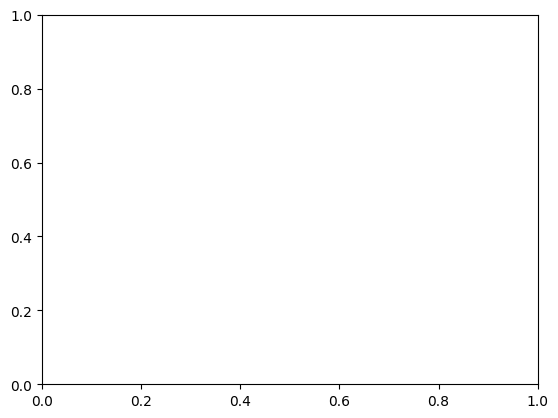

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.figure import Figure
from matplotlib.backends.backend_agg import FigureCanvasAgg
import imageio


# Other variables defined in the data import section ^^
N = window_size #500k samples
fs = 2e6 # Sampling rate - LIMESDR
t = np.arange(N) / fs # Time vector

fig, ax = plt.subplots()  # Set up the plotting figure and axis
images = []  # List to store each image plot

# Process each window and create plot data
for i, nn in enumerate(windows[0:190]):

    fig = Figure(figsize=(8, 6))  # Adjust size as needed
    canvas = FigureCanvasAgg(fig)
    ax = fig.add_subplot(111)

    fmap = np.arange(-(bs * 0.3), bs * 0.3, 2)
    rdmapX = np.zeros((len(fmap), len(nn)), dtype=complex)
    nn2F = np.conj(np.fft.fft(nn))

    for fi, f in enumerate(fmap):
        nnf = nn * np.exp(1j * 2 * np.pi * -f * t)
        rdmapX[fi, :] = np.fft.ifft(np.fft.fft(nnf) * nn2F)

    rdmapXTRUNC = np.abs(rdmapX[:, 1:overlap])
    print(f"Truncated Range Doppler Data: {rdmapXTRUNC[:, 1:5]}")
    
    ## DATA STUFFFF
    #Skip the zero range column - SHOW LOG10 of data np.log10
    image = ax.imshow(np.log10(rdmapXTRUNC), extent=[1, overlap, np.min(fmap), np.max(fmap)], aspect='auto')
    ax.set_xlabel('Range (samples)')
    ax.set_ylabel('Doppler (Hz)')
    ax.set_title(f"Window {i+1}")

    # Convert plot to image
    canvas.draw()
    image = np.frombuffer(canvas.buffer_rgba(), dtype='uint8')
    image = image.reshape(canvas.get_width_height()[::-1] + (4,))
    
    # Convert RGBA to RGB
    image_rgb = image[:, :, :3]
    
    images.append(image_rgb)
    
    print(f"Processed window {i+1} of {len(windows)}")

    plt.close(fig)  # Close the figure to free up memory

# Set up animation
# Save as a Gif
imageio.mimsave(GIFsaveName, images, fps=5) 

# Display the animation
#plt.show()
